In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import cv2
from tensorflow.keras.utils import Sequence

# ✅ Custom data generator that converts RGB to Lab
class LabDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=6, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []

        for path in batch_paths:
            img_bgr = cv2.imread(path)
            img_bgr = cv2.resize(img_bgr, self.target_size)
            img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype('float32')
            img_lab[:, :, 0] = img_lab[:, :, 0] / 100.0     # L channel [0, 100]
            img_lab[:, :, 1:] = (img_lab[:, :, 1:] + 128) / 255.0  # a,b channels [-128, 127] to [0,1]
            images.append(img_lab)

        X = np.array(images)
        y = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)

# ✅ Load image paths and labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_image_paths_labels(directory):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(directory, target_size=(224, 224), batch_size=1, shuffle=False)
    filepaths = [gen.filepaths[i] for i in range(len(gen.filepaths))]
    labels = gen.classes
    return filepaths, labels, gen.class_indices

train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

train_paths, train_labels, class_indices = get_image_paths_labels(train_dir)
val_paths, val_labels, _ = get_image_paths_labels(val_dir)
test_paths, test_labels, _ = get_image_paths_labels(test_dir)

# ✅ Create Lab data generators
batch_size = 32
train_generator = LabDataGenerator(train_paths, train_labels, batch_size)
val_generator = LabDataGenerator(val_paths, val_labels, batch_size, shuffle=False)
test_generator = LabDataGenerator(test_paths, test_labels, batch_size, shuffle=False)

# ✅ Build VGG19 model for Lab input
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=30)

# ✅ Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Train vs Val Accuracy (Lab - VGG19)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy LAB: {test_acc:.4f}")

# ✅ Confusion matrix
y_true = np.array(test_labels)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Lab VGG19")
plt.show()


2025-07-19 17:33:22.825072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752946403.103620      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752946403.188950      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 46646 images belonging to 6 classes.
Found 9993 images belonging to 6 classes.
Found 10001 images belonging to 6 classes.


I0000 00:00:1752946438.208929      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1752946445.971761     113 service.cc:148] XLA service 0x7ca704010c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752946445.972901     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752946446.433096     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1458 ━━━━━━━━━━━━━━━━━━━━ 2:10 90ms/step - accuracy: 0.1250 - loss: 5.0423  

I0000 00:00:1752946454.925718     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1458/1458 ━━━━━━━━━━━━━━━━━━━━ 479s 321ms/step - accuracy: 0.7008 - loss: 0.9362 - val_accuracy: 0.9744 - val_loss: 0.1012
Epoch 2/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 251s 172ms/step - accuracy: 0.8918 - loss: 0.2934 - val_accuracy: 0.9777 - val_loss: 0.0896
Epoch 3/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 244s 167ms/step - accuracy: 0.9048 - loss: 0.2749 - val_accuracy: 0.9811 - val_loss: 0.0623
Epoch 4/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 244s 167ms/step - accuracy: 0.9199 - loss: 0.2225 - val_accuracy: 0.9813 - val_loss: 0.0636
Epoch 5/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 243s 166ms/step - accuracy: 0.9270 - loss: 0.2010 - val_accuracy: 0.9834 - val_loss: 0.0541
Epoch 6/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 248s 170ms/step - accuracy: 0.9362 - loss: 0.1767 - val_accuracy: 0.9845 - val_loss: 0.0550
Epoch 7/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 248s 170ms/step - accuracy: 0.9339 - loss: 0.1831 - val_accuracy: 0.9855 - val_loss: 0.0515
Epoch 8/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 244s 167ms/step - accuracy: 0.9

2025-07-20 00:12:53.328566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752970373.513819      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752970373.564206      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 46646 images belonging to 6 classes.
Found 9993 images belonging to 6 classes.
Found 10001 images belonging to 6 classes.


I0000 00:00:1752970547.705016      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1752970556.009030     116 service.cc:148] XLA service 0x79de5000ff60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752970556.009870     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752970556.457111     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1458 ━━━━━━━━━━━━━━━━━━━━ 2:13 92ms/step - accuracy: 0.1172 - loss: 3.4748  

I0000 00:00:1752970564.987742     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1458/1458 ━━━━━━━━━━━━━━━━━━━━ 2020s 1s/step - accuracy: 0.7311 - loss: 0.7918 - val_accuracy: 0.9636 - val_loss: 0.1440
Epoch 2/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 306s 210ms/step - accuracy: 0.8749 - loss: 0.3281 - val_accuracy: 0.9663 - val_loss: 0.1276
Epoch 3/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 230s 158ms/step - accuracy: 0.8922 - loss: 0.2964 - val_accuracy: 0.9728 - val_loss: 0.0860
Epoch 4/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 235s 161ms/step - accuracy: 0.9115 - loss: 0.2413 - val_accuracy: 0.9688 - val_loss: 0.1053
Epoch 5/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 239s 164ms/step - accuracy: 0.9128 - loss: 0.2465 - val_accuracy: 0.9717 - val_loss: 0.0838
Epoch 6/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 234s 161ms/step - accuracy: 0.9206 - loss: 0.2259 - val_accuracy: 0.9766 - val_loss: 0.0777
Epoch 7/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 232s 159ms/step - accuracy: 0.9122 - loss: 0.2438 - val_accuracy: 0.9754 - val_loss: 0.0775
Epoch 8/30
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 239s 164ms/step - accuracy: 0.917

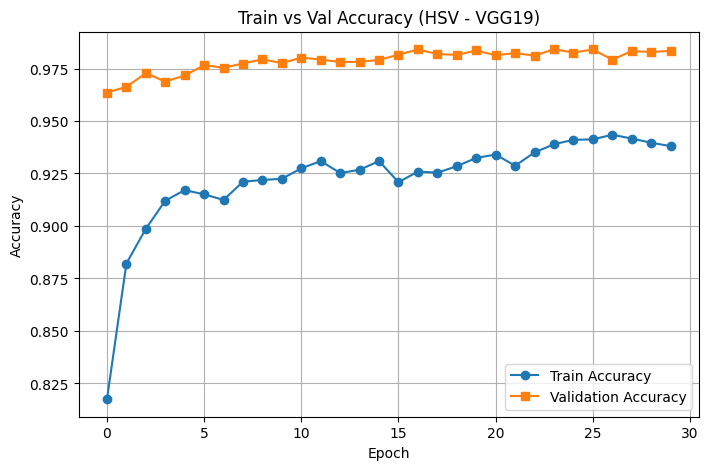

313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 325ms/step - accuracy: 0.9733 - loss: 0.1047

Test Accuracy HSV: 0.9830
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step

Classification Report HSV-VGG19:
                    precision    recall  f1-score   support

       ANTHRACNOSE       0.99      0.97      0.98      1634
           DIEBACK       1.00      1.00      1.00      1664
   GALLMIDGEDAMAGE       0.95      0.99      0.97      1596
           HEALTHY       0.99      0.99      0.99      1793
INSECTDAMAGEWEBBER       0.99      0.97      0.98      1671
        LEAFBLIGHT       0.98      0.98      0.98      1643

          accuracy                           0.98     10001
         macro avg       0.98      0.98      0.98     10001
      weighted avg       0.98      0.98      0.98     10001



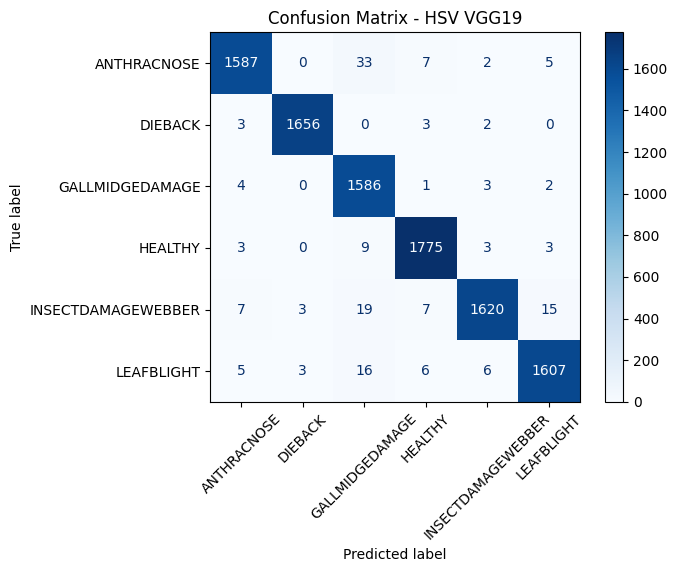

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Custom data generator for HSV images
class HSVDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=6, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []

        for path in batch_paths:
            img_bgr = cv2.imread(path)
            img_bgr = cv2.resize(img_bgr, self.target_size)
            img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype('float32')
            img_hsv[:, :, 0] /= 179.0  # H channel range: [0,179]
            img_hsv[:, :, 1] /= 255.0  # S channel range: [0,255]
            img_hsv[:, :, 2] /= 255.0  # V channel range: [0,255]
            images.append(img_hsv)

        X = np.array(images)
        y = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)

# ✅ Get image paths and labels
def get_image_paths_labels(directory):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(directory, target_size=(224, 224), batch_size=1, shuffle=False)
    filepaths = [gen.filepaths[i] for i in range(len(gen.filepaths))]
    labels = gen.classes
    return filepaths, labels, gen.class_indices

# ✅ Dataset paths
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

train_paths, train_labels, class_indices = get_image_paths_labels(train_dir)
val_paths, val_labels, _ = get_image_paths_labels(val_dir)
test_paths, test_labels, _ = get_image_paths_labels(test_dir)

# ✅ Create HSV data generators
batch_size = 32
train_generator = HSVDataGenerator(train_paths, train_labels, batch_size)
val_generator = HSVDataGenerator(val_paths, val_labels, batch_size, shuffle=False)
test_generator = HSVDataGenerator(test_paths, test_labels, batch_size, shuffle=False)

# ✅ Build VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=30)

# ✅ Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Train vs Val Accuracy (HSV - VGG19)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Evaluate and visualize
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy HSV: {test_acc:.4f}")

y_true = np.array(test_labels)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report HSV-VGG19:")
print(classification_report(y_true, y_pred, target_names=class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - HSV VGG19")
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Paths
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = 6

# Image generators (no augmentation)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical'
)
val_generator = datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical'
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers

# Classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_mango.keras', monitor='val_accuracy', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy RGTHERMAL_VGG16: {test_acc:.4f}")
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy with RGTHERMAL_VGG16')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Classification report
print("\nClassification Report with RGTHERMAL_VGG16:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Confusion Matrix - with RGTHERMAL_VGG16')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Confusion matrix and classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy RGTHERMAL_VGG16: {test_acc:.4f}")
# Classification Report
print("\n📊 Classification Report RGTHERMAL_VGG16:")
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - RGTHERMAL_VGG16")
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy RGTHERMAL_VGG16: {test_acc:.4f}")

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy with RGTHERMAL_VGG16')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import shutil
# =====================
# 💾 Save Model in All Formats
# =====================
os.makedirs('/kaggle/working/saved_models', exist_ok=True)

# 1. Full model (HDF5)
model.save('/kaggle/working/saved_models/RGTHERMAL_VGG16.h5')

# 2. Weights only
model.save_weights('/kaggle/working/saved_models/RGTHERMAL_VGG16.weights.h5')

shutil.make_archive('/kaggle/working/mango_RGTHERMAL_VGG16', 'zip', '/kaggle/working/saved_models')
print("\n✅ All models saved and zipped at /kaggle/working/mango_RGTHERMAL_VGG16.zip")